
[Plant Classification Report]

                             precision    recall  f1-score   support

pepper_bell__bacterial_spot       0.81      0.79      0.80       200
       pepper_bell__healthy       0.87      0.90      0.88       297
       potato__early_blight       0.96      0.97      0.96       206
            potato__healthy       0.81      0.54      0.65        24
      tomato_bacterial_spot       0.92      0.95      0.93       423
        tomato_early_blight       0.79      0.73      0.76       203
             tomato_healthy       0.96      0.98      0.97       316

                   accuracy                           0.89      1669
                  macro avg       0.87      0.84      0.85      1669
               weighted avg       0.89      0.89      0.89      1669



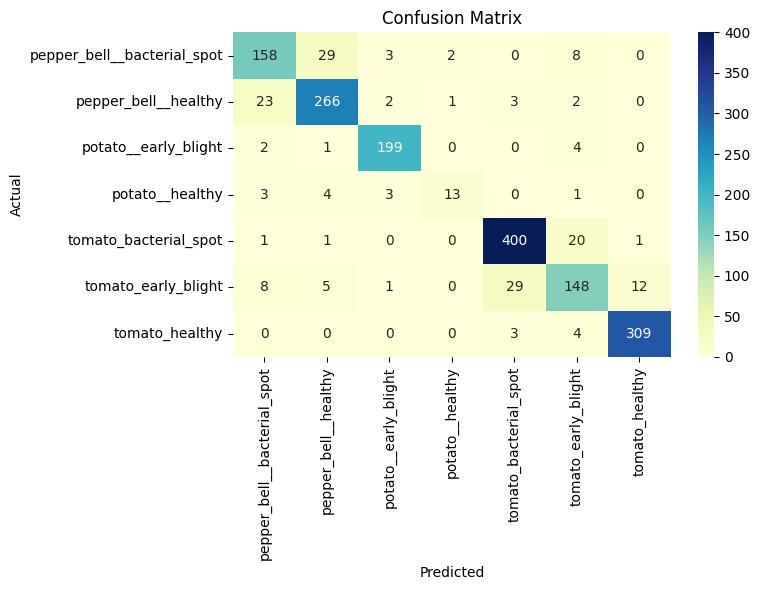


✅ Model, Scaler, and LabelEncoder saved.


In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
from skimage.feature import local_binary_pattern, hog
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------ FEATURE EXTRACTION ------------------------
def extract_handcrafted_features(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (128, 128))
    features = []

    # Color features
    avg_color = np.mean(img, axis=(0, 1))
    features.extend(avg_color)

    # Color histogram
    for i in range(3):
        hist = cv2.calcHist([img], [i], None, [16], [0, 256])
        hist = cv2.normalize(hist, hist).flatten()
        features.extend(hist)

    # Texture features (LBP)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(gray, P=8, R=1, method="uniform")
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 10), range=(0, 9))
    lbp_hist = lbp_hist.astype("float") / (lbp_hist.sum() + 1e-6)
    features.extend(lbp_hist)

    # Shape features (HOG)
    gray_resized = cv2.resize(gray, (64, 128))
    hog_features = hog(gray_resized, orientations=9, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), block_norm='L2-Hys', visualize=False)
    features.extend(hog_features)

    return np.array(features)

# ------------------------ LOAD DATA ------------------------
image_paths = glob("images/*/*.jpg")
data = []

for path in image_paths:
    folder = os.path.basename(os.path.dirname(path))
    label = folder.lower().replace("__", "_")  # clean labels
    features = extract_handcrafted_features(path)
    data.append({
        "path": path,
        "label": label,
        "features": features
    })

df = pd.DataFrame(data)
X = np.stack(df['features'])
y = df['label']

# ------------------------ ENCODING ------------------------
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# ------------------------ SCALING & SPLIT ------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

# Class weights
weights = class_weight.compute_sample_weight(class_weight='balanced', y=y_train)

# ------------------------ TRAINING ------------------------
clf = SVC(kernel='linear', probability=True)
clf.fit(X_train, y_train, sample_weight=weights)
y_pred = clf.predict(X_test)

# ------------------------ EVALUATION ------------------------
print("\n[Plant Classification Report]\n")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(y_test, y_pred, label_encoder.classes_)

# ------------------------ SAVE MODELS ------------------------
os.makedirs("models", exist_ok=True)
joblib.dump(clf, "models/species_model.pkl")
joblib.dump(scaler, "models/scaler.pkl")
joblib.dump(label_encoder, "models/label_encoder.pkl")

print("\n✅ Model, Scaler, and LabelEncoder saved.")
